In [1]:
import pandas as pd
import matplotlib
import math
import numpy as np
import statsmodels.api as sm

def linear_regression(design_matrix, target_vector):
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

In [2]:
col1 = [0,1,2,3,4,5,6]
col2 = [10,11,12,13,14,15,16]
col3 = [20,21,22,23,24,25,26]
test_df = pd.DataFrame({'a':col1, 'b':col2, 'c':col3})

The code essentially loops through the different series, performing an AR on each one.   

Used to have a vector of parameters now have a matrix of parameters  
One row for each series

all have different coefficients but all have the same inputs, depending on the lags

design matrix the same for each series, but target vector will be different




In [33]:
def train_var(df, order):
    param_rows = []
    dmnum = 0
    # loop through each series, doing AR on each one
    for column in df.columns:
        # first p (order) elements are missing 
        target_vector = np.array(df[column][order:])
        # print(target_vector)
        
        lagged_values = []
        # make design matrices
        for i in range(len(df[column]) - order):
            # start with 0's
            design_row = np.zeros(0)
            
            for param_col in df.columns:
                design_row = np.append(design_row, df[param_col][i:i+order])
            # get each row of lagged values for order 2 = 2 values from each series
            # print(design_row) => [0,1,10,11,20,21]
            lagged_values.append(design_row)
        design_matrix = np.array(lagged_values)
        # print('DESIGN MATRIX:', design_matrix)
        param_rows.append(linear_regression(design_matrix, target_vector))
    return np.array(param_rows)
    

# train_var(test_df, 3)

## Real Data
British GDP vs Job Vacancies
Couldn't find data
Imported different ones

In [26]:
df = pd.read_csv('./data/M2SLMoneyStock.csv')
df2 = pd.read_csv('./data/PCEPersonalSpending.csv')


In [27]:
df = df.set_index('Date').join(df2.set_index('Date'))

In [105]:
order = 4
df_test = df[100:116]

var_params = train_var(df,order)
var_params

array([[-0.08678108,  0.03802285, -0.09820925,  1.14791166,  0.04420334,
         0.05015833,  0.02024647, -0.11148272],
       [ 0.08357758,  0.00364851, -0.2489073 ,  0.15897149, -0.11556855,
        -0.04850428,  0.12608193,  1.04256798]])

Have 2 rows = 1 for each series
Each row has 6 parameters = 2 series * 3 order = 6


## Prediction



In [106]:
def predict_var(df, params):
    # compute the order of the VAR
    # divide cols (k*p) params by rows (p)
    order = params.shape[1] // params.shape[0]

    # create empty DF
    results = pd.DataFrame() 

    # outer loop - everything within it done to do predictions for all cols
    for column_num, column in enumerate(df.columns):
        # set first order numbers to nan as can't predict
        predicted_values = [math.nan]*order

        # inner loop
        for i in range(len(df[column]) - order):
            lags = np.zeros(0)
            # get order amount of lag values from the series column
            for param_column in df.columns:
                lags = np.append(lags, df[param_column][i : i + order])
                # print('take lags from ', param_column, 'to predict', column, lags)

            # Get predictions: combine lags and coefficients by dot product
            predicted_values.append(np.dot(lags, params[column_num, :]))
            # print(params[column_num, :])
        # add to results df
        results[column] = predicted_values
    return results


predictions = predict_var(df, var_params)
predictions.head()

,Money,Spending
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,3515.022509,4910.327952


In [107]:
def rmse(predicted, actual):
    # print(predicted, actual)1
    diffs = predicted - actual
    # print(diffs)
    return math.sqrt(np.mean(diffs ** 2))
    

VAR(4) Spending rmse 33.79412621383513
VAR(4) Money rmse 25.54172842969896


<AxesSubplot:>

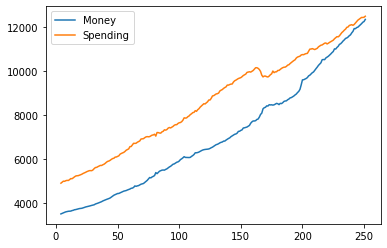

In [112]:
new_df = df.copy()
new_df = new_df.reset_index()
new_df = new_df.drop(['Date'], axis=1)
# new_df['Pred_Money'] = predictions['Money']
# new_df['Pred_Spending'] = predictions['Spending']

print("VAR(4) Spending rmse", rmse(new_df['Spending'], predictions['Spending']))
print("VAR(4) Money rmse", rmse(new_df['Money'], predictions['Money']))


predictions.plot()

<AxesSubplot:>

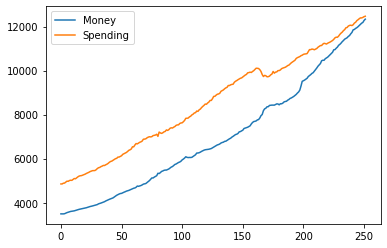

In [88]:
new_df.plot()

### Plot differences
This is the error, want them to hover around 0  
Can see here the error starts to trend for both of them

<AxesSubplot:>

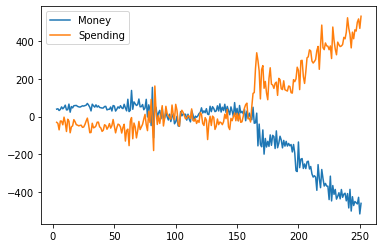

In [87]:
(predictions - new_df).plot()

## Compare results to an AR model alone

In [109]:
df_spending = new_df['Spending']
df_money = new_df['Money']

In [110]:
def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order])
    design_matrix = np.array(lagged_values)
    return linear_regression(design_matrix, target_vector)

def predict(coeffs, data):
    predicted_values = [math.nan] * len(coeffs)
    for i in range(len(coeffs), len(data)):
        predicted_values.append(np.dot(coeffs, data[i-len(coeffs):i]))
    return np.array(predicted_values)

In [114]:
spending_predict_ar4 = predict(train_ar(new_df['Spending'], 4), new_df['Spending'])
money_predict_ar4 = predict(train_ar(new_df['Money'], 4), new_df['Money'])
print("VAR(4) Spending rmse", rmse(new_df['Spending'], predictions['Spending']))
print('AR(4) Spending model rmse', rmse(spending_predict_ar4, new_df['Spending']))
print("VAR(4) Money rmse", rmse(new_df['Money'], predictions['Money']))
print('AR(4) Money model rmse', rmse(money_predict_ar4, new_df['Money']))

VAR(4) Spending rmse 33.79412621383513
AR(4) Spending model rmse 34.22652521137028
VAR(4) Money rmse 25.54172842969896
AR(4) Money model rmse 26.09486639534869


In this case VAR(4) model wins out

## Using Stats Models

Using AR model first

In [98]:
import statsmodels.api as sm
spending_model = sm.tsa.AutoReg(new_df['Spending'], lags=4, trend='n').fit()
money_model = sm.tsa.AutoReg(new_df['Money'], lags=4, trend='n').fit()

print('AR(4) spending model rmse', rmse(spending_model.predict(), new_df['Spending']))
print('AR(4) money model rmse', rmse(money_model.predict(), new_df['Money']))

AR(4) spending model rmse 34.22652521137028
AR(4) money model rmse 26.094866395348724


In [115]:
var_model = sm.tsa.VAR(new_df[['Spending', 'Money']]).fit(4,trend='n')

print('VAR model SPENDING rmse', rmse(var_model.resid['Spending'],0))
print('VAR model Money rmse', rmse(var_model.resid['Money'],0))

var_model.params

VAR model SPENDING rmse 33.79412621383522
VAR model Money rmse 25.541728429698818


,Spending,Money
L1.Spending,1.042568,-0.111483
L1.Money,0.158971,1.147912
L2.Spending,0.126082,0.020246
L2.Money,-0.248907,-0.098209
L3.Spending,-0.048504,0.050158
L3.Money,0.003649,0.038023
L4.Spending,-0.115569,0.044203
L4.Money,0.083578,-0.086781
